# Rock-Paper-Scissors (RPS) classification using PyTorch


Authors : 
- Youssef Achenchabe
- Mehdi Ghouwati Badreddine


In this notebook we will try to classify the RPS dataset. (https://github.com/YoussefAch/RPS-classification-using-PyTorch) using a fully connected neural network. This notebook is inspired from the MNIST example from PyTorch (https://github.com/pytorch/examples/tree/master/mnist).

## RPS dataset

We have created this 3 class dataset in a group of 28 M2 students at ENSEEIHT, it contains 70 images (32 x 32) per class. We know that the number of images in this dataset is too slow to train a neural network. The main objective of this notebook is to prototype and start getting hands dirty with pytorch.

![RPS_dataset](RPS-dataset.jpg)

#### let's import some libraries first

In [1]:
import numpy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

import PIL
from torch.utils.data.dataset import Dataset
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision import datasets
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

#### For reproducibility

In [2]:
SEED = 1
torch.manual_seed(SEED)

#### Define the transformations on the images : Rotation and Grayscale tranform

In [19]:
imageTransformation = transforms.Compose([transforms.Grayscale(),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomRotation(30, resample=PIL.Image.BILINEAR),transforms.ToTensor(),
                                          transforms.Normalize(mean=torch.tensor(0.4635).view(1, -1),
                                                            std=torch.tensor(0.2200).view(1, -1))])

#### Load the dataset and apply the transformations

In [20]:
imagesData = datasets.ImageFolder('PPC/.',imageTransformation)

#### Split the dataset into train and test (80%, 20%)

In [21]:
nbTrain = int(0.8*len(imagesData))
nbTest = len(imagesData) - nbTrain
train_data, test_data = torch.utils.data.random_split(imagesData, [nbTrain, nbTest])

#### Create dataloaders and iterator 

In [22]:
batch = int(nbTrain/6)
dataloader_args_train = dict(shuffle=True, batch_size=batch,num_workers=4, pin_memory=True)
dataloader_args_test = dict(shuffle=True, batch_size=nbTest,num_workers=4, pin_memory=True)
train_loader = dataloader.DataLoader(train_data, **dataloader_args_train)
test_loader = dataloader.DataLoader(test_data, **dataloader_args_test)
iterator = iter(test_loader)
img, lb = iterator.next()

#### Compute the mean and the stadard deviation of the images

In [23]:
n_samples_seen = 0.
mean = 0
std = 0
for train_batch, train_target in train_loader:
    batch_size = train_batch.shape[0]
    train_batch = train_batch.view(batch_size, -1)
    this_mean = torch.mean(train_batch, dim=1)
    this_std = torch.sqrt(
        torch.mean((train_batch - this_mean[:, None]) ** 2, dim=1))
    mean += torch.sum(this_mean, dim=0)
    std += torch.sum(this_std, dim=0)
    n_samples_seen += batch_size

mean /= n_samples_seen
std /= n_samples_seen

#### Define the model (fully connected neural network with two hidden layers)

In [24]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(1024, 20)
        self.fc1 = nn.Linear(20, 40)
        self.fc2 = nn.Linear(40, 3)

    def forward(self, x):
        x = x.view((-1, 1024))
        h = F.relu(self.fc(x))
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        return F.log_softmax(h, dim=0) 

#### Initialize the model and the optimizer

In [25]:
model = Model()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#### Set the parameters of the training 

In [26]:
EPOCHS = 100
losses = []

#### Train the neural network

In [28]:
model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        

        # Init
        optimizer.zero_grad()
        # Predict
        y_pred = model(data) 

         
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().item())
        
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % batch == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                nbTrain,
                100. * batch_idx / batch, 
                loss.cpu().item()), 
                end='')
            
    # display final evaluation for this epoch
    model.eval()
    output = model(img)
    pred = output.data.max(1)[1]
    d = pred.eq(lb.data).cpu()
    accuracy = d.sum().item()/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        nbTrain, 
        nbTrain,
        100. * batch_idx / batch, 
        loss.cpu().item(),
        accuracy*100,
        end=''))

 Train Epoch: 1/100 [161/161 (23%)]	Loss: 1.103318	 Test Accuracy: 34.1463%
 Train Epoch: 2/100 [161/161 (23%)]	Loss: 1.071839	 Test Accuracy: 48.7805%
 Train Epoch: 3/100 [161/161 (23%)]	Loss: 1.056955	 Test Accuracy: 39.0244%
 Train Epoch: 4/100 [161/161 (23%)]	Loss: 1.065645	 Test Accuracy: 39.0244%
 Train Epoch: 5/100 [161/161 (23%)]	Loss: 0.977084	 Test Accuracy: 43.9024%
 Train Epoch: 6/100 [161/161 (23%)]	Loss: 1.067446	 Test Accuracy: 41.4634%
 Train Epoch: 7/100 [161/161 (23%)]	Loss: 1.156487	 Test Accuracy: 43.9024%
 Train Epoch: 8/100 [161/161 (23%)]	Loss: 1.194788	 Test Accuracy: 31.7073%
 Train Epoch: 9/100 [161/161 (23%)]	Loss: 0.982926	 Test Accuracy: 39.0244%
 Train Epoch: 10/100 [161/161 (23%)]	Loss: 1.196486	 Test Accuracy: 46.3415%
 Train Epoch: 11/100 [161/161 (23%)]	Loss: 1.027245	 Test Accuracy: 29.2683%
 Train Epoch: 12/100 [161/161 (23%)]	Loss: 0.842673	 Test Accuracy: 26.8293%
 Train Epoch: 13/100 [161/161 (23%)]	Loss: 0.954529	 Test Accuracy: 34.1463%
 Train E

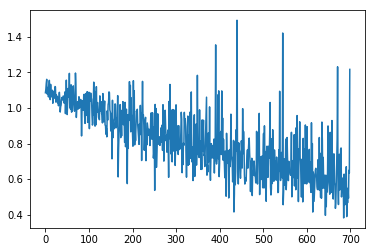

In [29]:
plt.plot(losses)

## The normalization of the images has improved the result and the convergence of our neural network 